In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.plotting import plot_trajectory
from utils.processing import (
    open_file,
    cut_jumps,
    open_preprocessed_data,
)

In [2]:
#p_move = 0.6420212579051949
#p_stop = 0.3579787420948051

N = 400
p_move_wall =  0.6695382543506487
p_move_cent = 0.8409691497345833
p_move_corn = 0.5605901660833496

#data-based angle, step distributions
import pickle

with open('New_DeltaAng_Distr_nbins_60.pkl', 'rb') as fp:
    angleDistr = pickle.load(fp)
del angleDistr['wall']

with open('New_Walls_Distr_nbins_60.pkl', 'rb') as fp:
    angWallDistr = pickle.load(fp)
    
with open('New_Step_Distr_nbins_60.pkl', 'rb') as fp:
    stepLenDistr = pickle.load(fp)



In [3]:
# plt.figure()
# plt.hist(mm0)
# plt.figure()
# plt.hist(mmC)
# plt.figure()
# plt.hist(mmW)


In [4]:
# TODO: did I get correctly that you use original distributions to sample angles here? Yes
# TODO: but u use fitted distribution for step lens. Yes 
# TODO: there is no sitting? or it is in step len? need to add. 

# TODO: validate distributions!!!!

def makeNewTraj(N, area_borders=[-40, 40]):
    print('ho')
    mm0 = random.choices(stepLenDistr['center'][0], weights = stepLenDistr['center'][1], k = N)
    mmC = random.choices(stepLenDistr['corner'][0], weights = stepLenDistr['corner'][1], k = N)
    mmW = random.choices(stepLenDistr['wall'][0], weights = stepLenDistr['wall'][1], k = N)

    x = 0
    y = 0
    near = 0
    ang = 0
    ang_trig = 360 + 90 - ang
    if ang_trig > 360:
        ang_trig -= 360
    x_all = [0]
    y_all = [0]
    near_all = [0]
    angle_all = [0]
    ang_trig_all = [90]
    lastNear = False

    i = 0
    while i < N:
        print(i)
        x = x_all[i]
        y = y_all[i]
        # Sample step len
        near = near_all[i]
        if near == 0:
            tryMove = random.choices([1, 0], [p_move_cent, 1-p_move_cent], k = 1)[0]
            if tryMove == 1:
                step = mm0[i]
            else:
                step = 0
        elif near >= 10:
            tryMove = random.choices([1, 0], [p_move_corn, 1-p_move_corn], k = 1)[0]
            if tryMove == 1:
                step = mmC[i]
            else:
                step = 0
        elif (near >= 1) and (near <= 4):
            tryMove = random.choices([1, 0], [p_move_wall, 1-p_move_wall], k = 1)[0]
            if tryMove == 1:
                step = mmW[i]
            else:
                step = 0

        angle = angle_all[i]
        # angle_trig = ang_trig_all[i]
        if angle > 360:
            print("alarm")

        #варики в разных зонах
        if near == 0:
            deltang = random.choices(angleDistr['center'][0], weights = angleDistr['center'][1], k=1)[0]
            ang += deltang

        elif (near == 2) or (near == 4):
            if ((angle >= -25) and (angle <= 25)) or ((angle >= 155) and (angle <= 205)) or (angle > 335):
                deltang = random.choices(angWallDistr['par24'][0], weights = angWallDistr['par24'][1], k = 1)[0]
                #print('yes')
            else:
                deltang = random.choices(angWallDistr['reg24'][0], angWallDistr['reg24'][1], k = 1)[0]
            ang += deltang

        elif (near==1) or (near==3):
            # TODO change for my angles 
            if ((ang >= - 65) and (ang < 65)) or (ang > 295) or ((angle > 115) and (angle < 245)):
                deltang = random.choices(angWallDistr['reg13'][0], weights = angWallDistr['reg13'][1], k = 1)[0]
            else:
                #print('yes')
                deltang = random.choices(angWallDistr['par13'][0], weights = angWallDistr['par13'][1], k = 1)[0]
            ang += deltang

        # TODO: might be like that, should check relative angle distribution (or dangle) in 1&3 and 2&4 zones
        # TODO: the same with distr for parallel to walls or not
        #elif (near >= 1) and (near <= 4):
            #deltang = random.choices(angleDistr['wall'][0], weights = angleDistr['wall'][1], k = 1)[0]
            #ang += deltang

        elif (near >= 10) and (near <= 40):  # TODO: corner distr the same for each corner?
            deltang = random.choices(angleDistr['corner'][0], weights = angleDistr['corner'][1], k = 1)[0]
            ang += deltang
        else:
            raise ValueError(f'Error with near value = {near}')     # TODO debug ????? 

        # normalization TODO
        if ang < 0:
            ang += 360
        if ang > 360:
            ang -= 360
        if ang > 360:
            print('too big value of ang')
            ang -= 360
            print(ang)

        # TODO: ???? can get it 
        ang_trig = 360 + 90 - ang
        if ang_trig >= 360:
            ang_trig -= 360
        if ang_trig >= 360:
            ang_trig -= 360

        # вычислим x y из step и ang
        # by Forward Euler :)
        dt = 1
        dx = step * np.cos(np.deg2rad(ang_trig))
        dy = step * np.sin(np.deg2rad(ang_trig))
        x += dx
        y += dy

        # Calc new near wall
        # TODO: to params all
        # TODO: at the very end of code, cause x&y overshoot might lead to errors
        # TODO: where is "=>", everywhere "=" only, might cause errors
        if x < -32:
            if y > 32:
                near = 40
            elif y < -32:
                near = 30
            else:
                near = 4
        elif x > 32:
            if y > 32:
                near = 10
            elif y < -32:
                near = 20
            else:
                near = 2
        elif y > 32:
            near = 1
        elif y < -32:
            near = 3
        elif (x >= -32) and (y <= 32) and (y >= -32) and (x <= 32):
        # elif (x > -32) and (y < 32) and (y > -32) and (x < 32):
            near = 0
        else:
            raise ValueError(f'near mistake, near = {near}')  # TODO debug ?????

        # TODO: ???? cant understand what is it 
        if (x >= -40) and (x <= 40) and (y >= -40) and (y <= 40):
            if lastNear and (near == 0):
                tryEscWall = random.choices([1, 0], [0.15, 0.85], k = 1)[0]
                if tryEscWall == 1:
                    x_all.append(x)
                    y_all.append(y)
                    angle_all.append(ang)
                    ang_trig_all.append(ang_trig)
                    near_all.append(near)
                    # print('ok')
                    i += 1
                    if (near > 0) and (near <= 4):
                        lastNear=True
                    else:
                        lastNear = False

                elif tryEscWall == 0:
                    print('mouse you cant escape wall')
            else:            
                x_all.append(x)
                y_all.append(y)
                angle_all.append(ang)
                ang_trig_all.append(ang_trig)
                near_all.append(near)

                # print('ok')
                i += 1
                if (near > 0) and (near <= 4):
                    lastNear=True 
                else:
                    lastNear = False
        #else:
            # TODO: normalize x and y coords ???
            # or drop?
            # TODO: use list "area_borders" and hard code coords
            #print('mice run from the field')

    nn = len(x_all)
    time = np.linspace(0, nn * 0.3,nn)
    df = pd.DataFrame(list(zip(time,x_all, y_all, near_all)),columns =['time','x', 'y', 'near'])
    plt.figure()
    #plot_trajectory(df['x'], df['y']) # TODO
    plt.show()
    return df


In [7]:
kk = []
for i in range(5):
    kk.append(makeNewTraj(2000))
    
    

ho
0
1
2
3
4
5
6
7
mouse you cant escape wall
7
8
9
9
10
11
12
13
14
15
16
17
18
19
20
mouse you cant escape wall
20
21
22
23
23
24
25
26
27
28
29
30
31
31
32
33
33
34
35
36
36
37
37
37
38
39
40
40
40
41
42
43
44
45
45
46
47
48
49
50
51
52
53
54
55
56
57
58
58
58
59
59
60
61
62
62
63
64
65
66
67
67
67
68
69
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
88
88
88
88
88
89
90
90
90
90
90
90
91
92
93
94
95
96
mouse you cant escape wall
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
122
123
124
125
125
125
126
127
127
128
129
130
131
131
132
132
133
134
135
136
137
138
139
140
141
142
143
143
144
145
mouse you cant escape wall
145
146
146
146
146
147
148
149
150
151
152
153
154
155
155
155
156
157
158
158
158
158
158
159
160
161
162
163
163
163
164
164
165
166
166
167
167
168
169
170
171
172
173
173
173
174
175
176
177
178
179
180
181
182
183
184
185
185
186
187
188
189
190
191
192
193
194
mouse you cant escape wall
194


<Figure size 640x480 with 0 Axes>

ho
0
1
2
3
4
5
6
7
8
9
mouse you cant escape wall
9
mouse you cant escape wall
9
10
11
12
13
14
15
mouse you cant escape wall
15
mouse you cant escape wall
15
mouse you cant escape wall
15
16
17
18
19
20
mouse you cant escape wall
20
20
mouse you cant escape wall
20
21
22
23
24
25
26
27
28
29
30
30
31
32
32
33
34
34
35
36
36
mouse you cant escape wall
36
mouse you cant escape wall
36
37
38
39
40
40
40
41
42
43
44
45
mouse you cant escape wall
45
45
45
45
45
45
45
45
45
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
61
62
63
64
65
66
67
68
69
70
71
72
mouse you cant escape wall
72
72
73
mouse you cant escape wall
73
mouse you cant escape wall
73
74
75
76
77
78
79
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
102
102
102
103
104
105
106
107
108
109
110
111
112
113
mouse you cant escape wall
113
114
115
116
117
118
119
120
121
122
123
124
124
125
126
127
128
129
130
131
131
132
133
134
135
135
136
137
137
138
138
138
139
140
141
142
143
144
144
145
mouse y

<Figure size 640x480 with 0 Axes>

ho
0
1
2
3
4
5
6
7
8
9
10
mouse you cant escape wall
10
mouse you cant escape wall
10
11
12
13
14
15
16
mouse you cant escape wall
16
mouse you cant escape wall
16
17
17
mouse you cant escape wall
17
17
18
mouse you cant escape wall
18
19
19
20
21
22
23
24
25
25
26
26
27
28
mouse you cant escape wall
28
29
30
31
32
33
34
35
36
37
38
39
39
40
41
41
41
41
41
42
43
44
45
mouse you cant escape wall
45
46
47
47
48
49
50
51
52
53
54
55
56
57
58
mouse you cant escape wall
58
mouse you cant escape wall
58
mouse you cant escape wall
58
58
59
60
61
61
61
62
63
64
64
65
66
67
mouse you cant escape wall
67
mouse you cant escape wall
67
mouse you cant escape wall
67
mouse you cant escape wall
67
mouse you cant escape wall
67
mouse you cant escape wall
67
68
69
69
69
69
69
70
71
72
73
74
75
76
77
78
78
79
80
81
82
83
83
84
85
86
87
87
88
89
89
89
89
89
90
91
92
93
93
93
93
93
93
93
93
93
93
94
mouse you cant escape wall
94
mouse you cant escape wall
94
95
96
97
98
99
100
100
101
102
102
102
102
mous

<Figure size 640x480 with 0 Axes>

ho
0
1
2
3
4
5
6
7
8
9
10
11
12
13
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
43
44
45
46
47
48
48
49
50
51
52
53
54
55
56
57
58
59
60
61
61
62
63
64
65
65
66
67
68
68
69
70
70
71
72
73
74
75
76
77
78
79
80
81
82
83
mouse you cant escape wall
83
84
85
85
86
86
87
mouse you cant escape wall
87
mouse you cant escape wall
87
88
89
90
91
mouse you cant escape wall
91
91
92
93
94
94
95
96
97
98
99
99
99
99
mouse you cant escape wall
99
99
100
101
102
103
mouse you cant escape wall
103
103
103
104
105
106
106
106
106
106
107
108
109
110
110
111
112
112
113
114
114
115
116
mouse you cant escape wall
116
117
118
119
119
120
121
122
123
123
123
124
125
mouse you cant escape wall
125
126
126
126
mouse you cant escape wall
126
mouse you cant escape wall
126
mouse you cant escape wall
126
127
127
127
128
129
130
131
132
132
133
134
135
mouse you cant escape wall
135
mouse you cant escape wall
135
mouse you cant escape wall
135
136
137
138
139
140
1

<Figure size 640x480 with 0 Axes>

ho
0
1
2
3
4
5
6
6
7
8
9
mouse you cant escape wall
9
10
11
11
12
mouse you cant escape wall
12
12
mouse you cant escape wall
12
13
14
15
mouse you cant escape wall
15
16
17
18
mouse you cant escape wall
18
mouse you cant escape wall
18
18
18
19
20
21
22
23
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
mouse you cant escape wall
39
40
41
mouse you cant escape wall
41
42
43
44
45
46
mouse you cant escape wall
46
mouse you cant escape wall
46
47
48
49
50
51
52
53
53
54
mouse you cant escape wall
54
mouse you cant escape wall
54
55
56
57
58
59
60
mouse you cant escape wall
60
60
60
60
60
61
mouse you cant escape wall
61
mouse you cant escape wall
61
61
61
61
61
mouse you cant escape wall
61
62
63
mouse you cant escape wall
63
64
65
66
67
68
68
mouse you cant escape wall
68
68
68
68
69
70
71
72
73
74
75
76
77
78
79
80
80
mouse you cant escape wall
80
mouse you cant escape wall
80
81
82
83
83
mouse you cant escape wall
83
84
85
86
mouse you cant escape wall
86
mouse you cant escape wal

<Figure size 640x480 with 0 Axes>

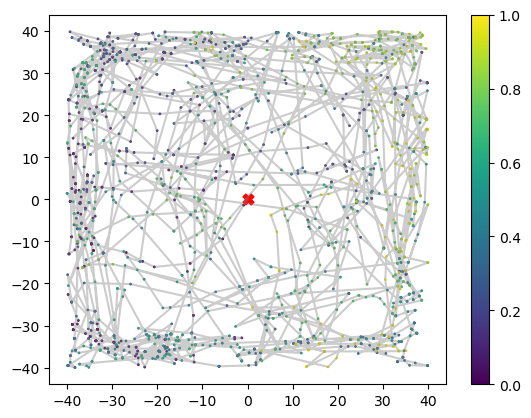

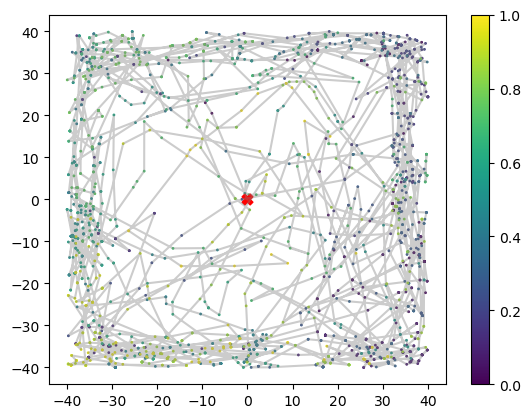

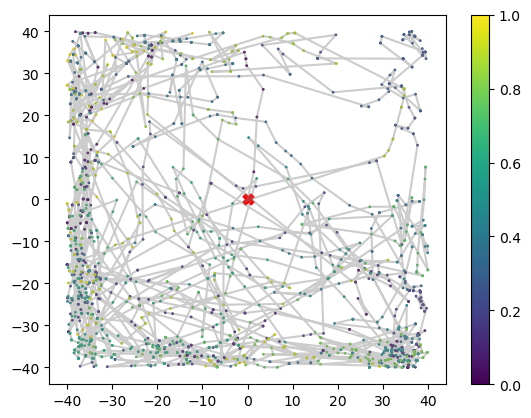

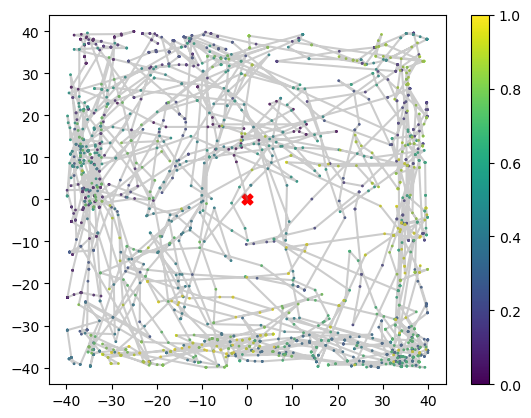

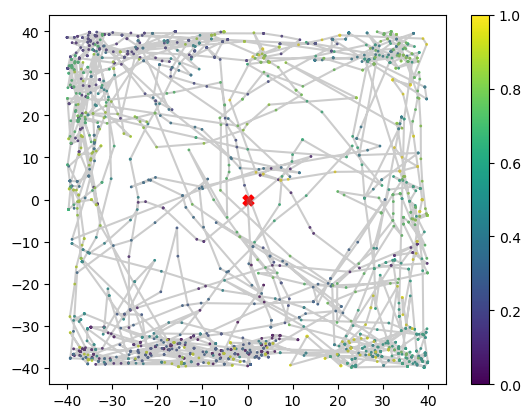

In [8]:
for d in kk:
    plt.figure()
    plot_trajectory(d['x'], d['y'])
    